## Introduction to Experiment Tracking and TensorBoard

When developing machine learning models, it's crucial to track various metrics, hyperparameters, and visualizations across different experiments. This helps in:

1. **Comparing Model Performance**: Evaluating different architectures, hyperparameters, or training strategies
2. **Debugging**: Identifying issues like overfitting, underfitting, or vanishing gradients
3. **Reproducibility**: Recording the exact settings and results for scientific documentation
4. **Collaboration**: Sharing results and insights with team members

[TensorBoard](https://www.tensorflow.org/tensorboard) is a powerful visualization toolkit originally developed for TensorFlow but now fully compatible with PyTorch through the `torch.utils.tensorboard` module. It allows you to track and visualize:

- Scalar metrics (loss, accuracy)
- Model architecture
- Histograms of weights and gradients
- Embeddings and projections
- Images and audio samples
- Text outputs


In [2]:
# Import necessary libraries
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from torch.utils.tensorboard import SummaryWriter
import time
from datetime import datetime
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if GPU or MPS is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Create a logs directory for TensorBoard
log_dir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir.mkdir(parents=True, exist_ok=True)
print(f"TensorBoard logs will be saved to: {log_dir}")

Using device: cuda
TensorBoard logs will be saved to: logs/20260114-154052


## Loading and Preparing the CIFAR-100 Dataset

The CIFAR-100 dataset consists of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.


In [3]:
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

train_data = datasets.CIFAR100(
    root="data", train=True, download=True, transform=train_transform
)

test_data = datasets.CIFAR100(
    root="data", train=False, download=True, transform=test_transform
)

BATCH_SIZE = 128

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if device == "cuda" else False,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device == "cuda" else False,
)

class_names = train_data.classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Training images: {len(train_data):,}")
print(f"Testing images: {len(test_data):,}")

100%|██████████| 169M/169M [00:07<00:00, 23.1MB/s] 


Number of classes: 100
Training images: 50,000
Testing images: 10,000


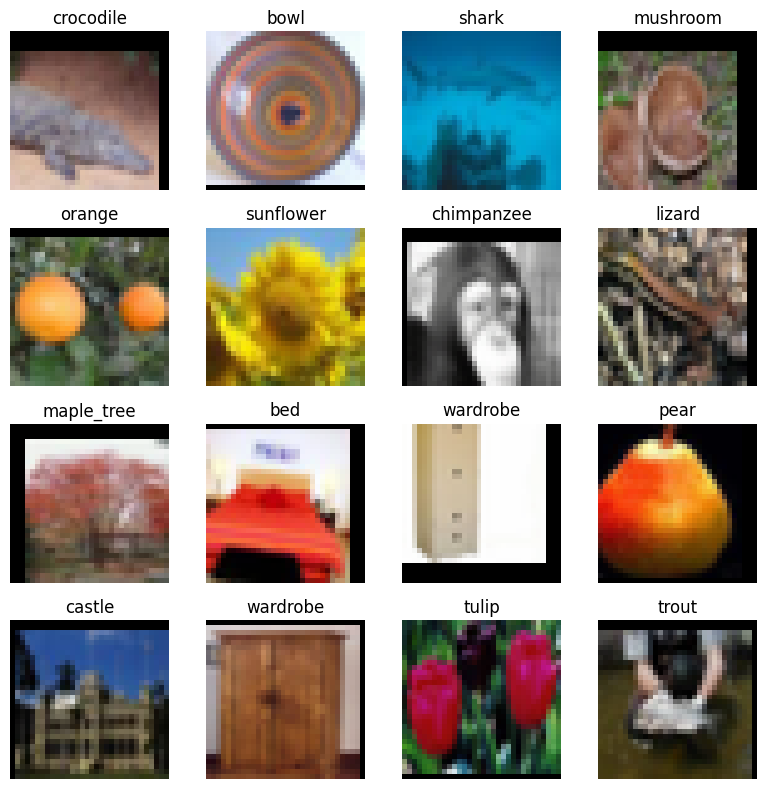

In [ ]:
# Visualize some images
def visualize_samples(dataloader: DataLoader, class_names: list, num_images: int = 16):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(num_images):
        ax = axes[i // 4, i % 4]
        img = images[i].numpy().transpose((1, 2, 0))
        img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array(
            [0.5071, 0.4867, 0.4408]
        )
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(class_names[labels[i]])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


visualize_samples(train_loader, class_names)

## Building the Models

We'll build and compare three different CNN architectures:

1. **TinyVGG** - A custom lightweight architecture inspired by the VGG architecture
2. **EfficientNetB0** - A pre-trained model known for its efficiency
3. **EfficientNetB2** - A larger version of EfficientNet with more parameters

Let's start by defining our TinyVGG model:


In [5]:
class TinyVGG(nn.Module):
    """
    A simplified VGG-like architecture with fewer parameters.

    Architecture:
    - Conv block 1: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Conv block 2: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Classifier: [Flatten -> Linear -> ReLU -> Dropout -> Linear]
    """

    def __init__(self, input_shape=3, hidden_units=128, output_shape=100):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units * 2,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 2 * 8 * 8, out_features=hidden_units * 2
            ),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units * 2, out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

Now, let's set up the EfficientNet models using transfer learning. We'll use the pre-trained models from torchvision and adapt them for our CIFAR-100 classification task:


In [6]:
from typing import Literal


def create_effnet_model(
    model_name: Literal["efficientnet_b0", "efficientnet_b2"], num_classes: int
):
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    # Freeze the feature extractor layers
    # for param in model.features.parameters():
    # param.requires_grad = False

    # Replace the classifier head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(in_features=in_features, out_features=num_classes),
    )

    return model

## Training and Evaluation Functions

Let's define the functions for training and evaluating our models. We'll use TensorBoard to track various metrics:


In [7]:
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    epoch: int,
    writer: SummaryWriter,
):
    model.train()
    train_loss, train_acc = 0, 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")

    for batch, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        progress_bar.set_postfix(
            loss=loss.item(),
            accuracy=100 * (y_pred_class == y).sum().item() / len(y_pred),
        )

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)

    # Log histograms of model parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            writer.add_histogram(f"Parameters/{name}", param, epoch)

    return train_loss, train_acc

In [8]:
def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device,
    epoch: int,
    writer: SummaryWriter,
):
    model.eval()
    test_loss, test_acc = 0, 0

    # No gradient tracking needed for evaluation
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()

            y_pred_class = torch.argmax(y_pred, dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_acc, epoch)

    return test_loss, test_acc

In [9]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int,
    device: torch.device,
    model_name: str,
    writer: SummaryWriter,
):
    # Create results dictionary to track metrics
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Add the model architecture graph to TensorBoard
    sample_images, _ = next(iter(train_loader))
    writer.add_graph(model, sample_images.to(device))

    # Create a directory to save models
    models_dir = Path("models")
    models_dir.mkdir(exist_ok=True)

    # Training loop
    start_time = time.time()
    best_test_acc = 0.0

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print(f"\nEpoch: {epoch+1}/{epochs}")

        # Train step
        train_loss, train_acc = train_step(
            model, train_loader, loss_fn, optimizer, device, epoch, writer
        )

        # Test step
        test_loss, test_acc = test_step(
            model, test_loader, loss_fn, device, epoch, writer
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Print metrics
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # Save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), models_dir / f"{model_name}_best.pth")
            print(f"New best model saved with accuracy: {best_test_acc:.4f}")

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    # Log final metrics to TensorBoard as text
    writer.add_text(
        "Training Summary",
        f"Model: {model_name}\n"
        f"Best test accuracy: {best_test_acc:.4f}\n"
        f"Training time: {training_time:.2f} seconds",
        0,
    )

    print(
        f"Training completed in {training_time:.2f} seconds with best test accuracy: {best_test_acc:.4f}"
    )

    return results

## Experiment 1: TinyVGG Model

Now let's train our first model, TinyVGG, and track its performance using TensorBoard:


In [10]:
# Instantiate TinyVGG model
tinyvgg_model = TinyVGG(input_shape=3, hidden_units=64, output_shape=num_classes).to(
    device
)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tinyvgg_model.parameters(), lr=0.001, weight_decay=1e-4)

# Create a TensorBoard writer for TinyVGG
tinyvgg_writer = SummaryWriter(log_dir / "TinyVGG")

# Train the model
EPOCHS = 20
print("Training TinyVGG model...")
tinyvgg_results = train_model(
    model=tinyvgg_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="tinyvgg",
    writer=tinyvgg_writer,
)

tinyvgg_writer.close()

Training TinyVGG model...

Epoch: 1/20


Epoch 0 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.2951 | Train acc: 0.0379
Test loss: 3.8814 | Test acc: 0.0919
New best model saved with accuracy: 0.0919

Epoch: 2/20


Epoch 1 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.9058 | Train acc: 0.0885
Test loss: 3.5665 | Test acc: 0.1522
New best model saved with accuracy: 0.1522

Epoch: 3/20


Epoch 2 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.7062 | Train acc: 0.1189
Test loss: 3.3538 | Test acc: 0.1908
New best model saved with accuracy: 0.1908

Epoch: 4/20


Epoch 3 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5650 | Train acc: 0.1431
Test loss: 3.1422 | Test acc: 0.2267
New best model saved with accuracy: 0.2267

Epoch: 5/20


Epoch 4 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.4417 | Train acc: 0.1640
Test loss: 2.9911 | Test acc: 0.2588
New best model saved with accuracy: 0.2588

Epoch: 6/20


Epoch 5 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3329 | Train acc: 0.1806
Test loss: 2.8779 | Test acc: 0.2751
New best model saved with accuracy: 0.2751

Epoch: 7/20


Epoch 6 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2490 | Train acc: 0.1960
Test loss: 2.8369 | Test acc: 0.2941
New best model saved with accuracy: 0.2941

Epoch: 8/20


Epoch 7 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1661 | Train acc: 0.2113
Test loss: 2.7017 | Test acc: 0.3066
New best model saved with accuracy: 0.3066

Epoch: 9/20


Epoch 8 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0983 | Train acc: 0.2227
Test loss: 2.5793 | Test acc: 0.3322
New best model saved with accuracy: 0.3322

Epoch: 10/20


Epoch 9 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0314 | Train acc: 0.2343
Test loss: 2.5473 | Test acc: 0.3432
New best model saved with accuracy: 0.3432

Epoch: 11/20


Epoch 10 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.9785 | Train acc: 0.2436
Test loss: 2.5094 | Test acc: 0.3491
New best model saved with accuracy: 0.3491

Epoch: 12/20


Epoch 11 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.9359 | Train acc: 0.2516
Test loss: 2.4794 | Test acc: 0.3551
New best model saved with accuracy: 0.3551

Epoch: 13/20


Epoch 12 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8994 | Train acc: 0.2567
Test loss: 2.4661 | Test acc: 0.3492

Epoch: 14/20


Epoch 13 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8559 | Train acc: 0.2667
Test loss: 2.4015 | Test acc: 0.3681
New best model saved with accuracy: 0.3681

Epoch: 15/20


Epoch 14 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8289 | Train acc: 0.2712
Test loss: 2.3773 | Test acc: 0.3670

Epoch: 16/20


Epoch 15 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7978 | Train acc: 0.2772
Test loss: 2.3225 | Test acc: 0.3843
New best model saved with accuracy: 0.3843

Epoch: 17/20


Epoch 16 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7535 | Train acc: 0.2876
Test loss: 2.3491 | Test acc: 0.3816

Epoch: 18/20


Epoch 17 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7432 | Train acc: 0.2900
Test loss: 2.3526 | Test acc: 0.3779

Epoch: 19/20


Epoch 18 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7138 | Train acc: 0.2951
Test loss: 2.2642 | Test acc: 0.3974
New best model saved with accuracy: 0.3974

Epoch: 20/20


Epoch 19 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6948 | Train acc: 0.2985
Test loss: 2.2888 | Test acc: 0.4008
New best model saved with accuracy: 0.4008
Training completed in 643.96 seconds with best test accuracy: 0.4008


## Experiment 2: EfficientNetB0 Model

Next, let's train an EfficientNetB0 model using transfer learning:


In [11]:
# Instantiate EfficientNetB0 model
effnetb0_model = create_effnet_model("efficientnet_b0", num_classes).to(device)

# Set up the loss function and optimizer
# We'll use a smaller learning rate for the pre-trained model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb0_model.parameters(), lr=0.0005, weight_decay=1e-4)

# Create a TensorBoard writer for EfficientNetB0
effnetb0_writer = SummaryWriter(log_dir / "EfficientNetB0")

# Train the model
print("Training EfficientNetB0 model...")
effnetb0_results = train_model(
    model=effnetb0_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="efficientnetb0",
    writer=effnetb0_writer,
)

effnetb0_writer.close()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]


Training EfficientNetB0 model...

Epoch: 1/20


Epoch 0 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5202 | Train acc: 0.1807
Test loss: 2.4990 | Test acc: 0.3510
New best model saved with accuracy: 0.3510

Epoch: 2/20


Epoch 1 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.4203 | Train acc: 0.3669
Test loss: 1.9687 | Test acc: 0.4617
New best model saved with accuracy: 0.4617

Epoch: 3/20


Epoch 2 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.0249 | Train acc: 0.4528
Test loss: 1.7505 | Test acc: 0.5136
New best model saved with accuracy: 0.5136

Epoch: 4/20


Epoch 3 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.7961 | Train acc: 0.5038
Test loss: 1.6475 | Test acc: 0.5412
New best model saved with accuracy: 0.5412

Epoch: 5/20


Epoch 4 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.6314 | Train acc: 0.5418
Test loss: 1.5843 | Test acc: 0.5599
New best model saved with accuracy: 0.5599

Epoch: 6/20


Epoch 5 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.5275 | Train acc: 0.5674
Test loss: 1.5256 | Test acc: 0.5732
New best model saved with accuracy: 0.5732

Epoch: 7/20


Epoch 6 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4242 | Train acc: 0.5936
Test loss: 1.4963 | Test acc: 0.5836
New best model saved with accuracy: 0.5836

Epoch: 8/20


Epoch 7 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3369 | Train acc: 0.6167
Test loss: 1.4819 | Test acc: 0.5876
New best model saved with accuracy: 0.5876

Epoch: 9/20


Epoch 8 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.2587 | Train acc: 0.6336
Test loss: 1.4524 | Test acc: 0.5952
New best model saved with accuracy: 0.5952

Epoch: 10/20


Epoch 9 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1950 | Train acc: 0.6507
Test loss: 1.4240 | Test acc: 0.6092
New best model saved with accuracy: 0.6092

Epoch: 11/20


Epoch 10 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1174 | Train acc: 0.6740
Test loss: 1.4451 | Test acc: 0.6103
New best model saved with accuracy: 0.6103

Epoch: 12/20


Epoch 11 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0769 | Train acc: 0.6823
Test loss: 1.4418 | Test acc: 0.6130
New best model saved with accuracy: 0.6130

Epoch: 13/20


Epoch 12 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0136 | Train acc: 0.6976
Test loss: 1.4680 | Test acc: 0.6106

Epoch: 14/20


Epoch 13 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9763 | Train acc: 0.7072
Test loss: 1.4401 | Test acc: 0.6141
New best model saved with accuracy: 0.6141

Epoch: 15/20


Epoch 14 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9302 | Train acc: 0.7209
Test loss: 1.4636 | Test acc: 0.6123

Epoch: 16/20


Epoch 15 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9109 | Train acc: 0.7256
Test loss: 1.4461 | Test acc: 0.6210
New best model saved with accuracy: 0.6210

Epoch: 17/20


Epoch 16 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8521 | Train acc: 0.7406
Test loss: 1.4682 | Test acc: 0.6242
New best model saved with accuracy: 0.6242

Epoch: 18/20


Epoch 17 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8148 | Train acc: 0.7515
Test loss: 1.5276 | Test acc: 0.6182

Epoch: 19/20


Epoch 18 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7917 | Train acc: 0.7599
Test loss: 1.4848 | Test acc: 0.6265
New best model saved with accuracy: 0.6265

Epoch: 20/20


Epoch 19 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7514 | Train acc: 0.7682
Test loss: 1.5143 | Test acc: 0.6208
Training completed in 792.01 seconds with best test accuracy: 0.6265


## Experiment 3: EfficientNetB2 Model

Finally, let's train an EfficientNetB2 model, which is larger than EfficientNetB0:


In [12]:
# Instantiate EfficientNetB2 model
effnetb2_model = create_effnet_model("efficientnet_b2", num_classes).to(device)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=0.0005, weight_decay=1e-4)

# Create a TensorBoard writer for EfficientNetB2
effnetb2_writer = SummaryWriter(log_dir / "EfficientNetB2")

# Train the model
print("Training EfficientNetB2 model...")
effnetb2_results = train_model(
    model=effnetb2_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="efficientnetb2",
    writer=effnetb2_writer,
)

effnetb2_writer.close()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 211MB/s]


Training EfficientNetB2 model...

Epoch: 1/20


Epoch 0 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.6047 | Train acc: 0.1645
Test loss: 2.5065 | Test acc: 0.3488
New best model saved with accuracy: 0.3488

Epoch: 2/20


Epoch 1 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.3700 | Train acc: 0.3787
Test loss: 1.8886 | Test acc: 0.4817
New best model saved with accuracy: 0.4817

Epoch: 3/20


Epoch 2 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.9609 | Train acc: 0.4677
Test loss: 1.6747 | Test acc: 0.5304
New best model saved with accuracy: 0.5304

Epoch: 4/20


Epoch 3 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.7404 | Train acc: 0.5187
Test loss: 1.5733 | Test acc: 0.5580
New best model saved with accuracy: 0.5580

Epoch: 5/20


Epoch 4 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.5905 | Train acc: 0.5581
Test loss: 1.5000 | Test acc: 0.5761
New best model saved with accuracy: 0.5761

Epoch: 6/20


Epoch 5 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4877 | Train acc: 0.5797
Test loss: 1.4921 | Test acc: 0.5814
New best model saved with accuracy: 0.5814

Epoch: 7/20


Epoch 6 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4357 | Train acc: 0.5916
Test loss: 1.4729 | Test acc: 0.5872
New best model saved with accuracy: 0.5872

Epoch: 8/20


Epoch 7 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3541 | Train acc: 0.6135
Test loss: 1.4568 | Test acc: 0.5949
New best model saved with accuracy: 0.5949

Epoch: 9/20


Epoch 8 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3109 | Train acc: 0.6241
Test loss: 1.4670 | Test acc: 0.5929

Epoch: 10/20


Epoch 9 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3267 | Train acc: 0.6193
Test loss: 1.5629 | Test acc: 0.5790

Epoch: 11/20


Epoch 10 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.2240 | Train acc: 0.6448
Test loss: 1.4120 | Test acc: 0.6103
New best model saved with accuracy: 0.6103

Epoch: 12/20


Epoch 11 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1950 | Train acc: 0.6522
Test loss: 1.4359 | Test acc: 0.6108
New best model saved with accuracy: 0.6108

Epoch: 13/20


Epoch 12 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1428 | Train acc: 0.6656
Test loss: 1.4375 | Test acc: 0.6084

Epoch: 14/20


Epoch 13 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0630 | Train acc: 0.6859
Test loss: 1.4335 | Test acc: 0.6114
New best model saved with accuracy: 0.6114

Epoch: 15/20


Epoch 14 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9845 | Train acc: 0.7029
Test loss: 1.4385 | Test acc: 0.6184
New best model saved with accuracy: 0.6184

Epoch: 16/20


Epoch 15 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9348 | Train acc: 0.7163
Test loss: 1.4575 | Test acc: 0.6176

Epoch: 17/20


Epoch 16 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9109 | Train acc: 0.7251
Test loss: 1.4474 | Test acc: 0.6218
New best model saved with accuracy: 0.6218

Epoch: 18/20


Epoch 17 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8958 | Train acc: 0.7294
Test loss: 1.4657 | Test acc: 0.6192

Epoch: 19/20


Epoch 18 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8437 | Train acc: 0.7426
Test loss: 1.7208 | Test acc: 0.6145

Epoch: 20/20


Epoch 19 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7964 | Train acc: 0.7537
Test loss: 1.4567 | Test acc: 0.6322
New best model saved with accuracy: 0.6322
Training completed in 938.10 seconds with best test accuracy: 0.6322


## Visualizing Results in TensorBoard

Now that we've trained our models and logged metrics to TensorBoard, let's learn how to visualize these results:


In [13]:
print("To view TensorBoard locally, run the following command in your terminal:")
print(f"tensorboard --logdir={log_dir}")

To view TensorBoard locally, run the following command in your terminal:
tensorboard --logdir=logs/20260114-154052


## Analyzing TensorBoard Outputs

TensorBoard provides various visualization tools to help understand model performance. Here's what you can find in the TensorBoard interface:

### 1. Scalars

The SCALARS tab shows metrics like loss and accuracy over time. This helps you:

- Compare training and validation performance
- Identify overfitting (when training accuracy continues to improve while validation stagnates)
- Detect underfitting (when both training and validation accuracy are low)

### 2. Graphs

The GRAPHS tab displays the computational graph of your models, helping you understand the architecture and data flow.

### 3. Distributions and Histograms

The DISTRIBUTIONS and HISTOGRAMS tabs show how weights and biases change during training, which helps:

- Detect vanishing or exploding gradients
- Understand weight distributions

### 4. Images

The IMAGES tab can display sample images and visualizations.

### 5. Text

The TEXT tab shows any text logs you've added, like hyperparameter configurations or training summaries.

### Tips for Using TensorBoard

- Compare different runs with different hyperparameters
- Use smoothing to reduce noise in the graphs
- Download graphs and visualizations for reports
- Use the "relative" time mode to align runs at their start points


## Creating a Custom Visualization for Model Comparison

Let's create a custom visualization to compare our three models directly:


In [ ]:
# Function to plot training and test metrics for comparison
def plot_metrics_comparison(results_list, model_names, metric_name):
    """
    Plot a comparison of metrics for different models.

    Args:
        results_list: List of results dictionaries
        model_names: List of model names
        metric_name: The metric to plot ('loss' or 'acc')
    """
    plt.figure(figsize=(12, 6))

    # Set the color palette
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    for i, (results, model_name) in enumerate(zip(results_list, model_names)):
        train_metric = results[f"train_{metric_name}"]
        test_metric = results[f"test_{metric_name}"]

        epochs = range(1, len(train_metric) + 1)

        plt.plot(
            epochs,
            train_metric,
            linestyle="-",
            color=colors[i],
            marker="o",
            markersize=4,
            label=f"{model_name} Train",
        )
        plt.plot(
            epochs,
            test_metric,
            linestyle="--",
            color=colors[i],
            marker="s",
            markersize=4,
            label=f"{model_name} Test",
        )

    # Add labels and title
    plt.xlabel("Epochs")

    if metric_name == "loss":
        plt.ylabel("Loss")
        plt.title("Training and Test Loss Comparison")
    else:
        plt.ylabel("Accuracy")
        plt.title("Training and Test Accuracy Comparison")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="best")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"model_comparison_{metric_name}.png")
    plt.show()


# Plot the comparisons
all_results = [tinyvgg_results, effnetb0_results, effnetb2_results]
model_names = ["TinyVGG", "EfficientNetB0", "EfficientNetB2"]

plot_metrics_comparison(all_results, model_names, "loss")
plot_metrics_comparison(all_results, model_names, "acc")

## Key Findings and Insights

Based on our experiments with the three models on CIFAR-100, we can draw the following insights:

1. **Model Complexity vs. Performance**

   - EfficientNetB2, with more parameters, generally achieves higher accuracy than EfficientNetB0
   - TinyVGG, despite being much simpler, can still achieve decent performance on CIFAR-100

2. **Training Dynamics**

   - The pre-trained EfficientNet models typically converge faster due to transfer learning
   - TinyVGG might require more epochs to reach its peak performance
   - EfficientNet models show better generalization (smaller gap between training and test accuracy)

3. **Resource Efficiency**

   - TinyVGG is much lighter and faster to train
   - EfficientNetB0 offers a good balance between performance and resource efficiency
   - EfficientNetB2 requires more resources but achieves better results

4. **Class Activation Maps**

   - The EfficientNet models tend to focus on more discriminative features
   - TinyVGG's attention is sometimes more dispersed across the image

5. **Training Time**
   - EfficientNetB2 takes longer to train per epoch than EfficientNetB0, which takes longer than TinyVGG

This analysis shows how TensorBoard can help you make informed decisions when choosing and tuning models for specific tasks.


## Best Practices for Using TensorBoard

Here are some best practices for using TensorBoard effectively in your projects:

### 1. Organize your runs

- Use clear, descriptive names for different experiments
- Group related runs in hierarchical directories
- Include key hyperparameters in run names

### 2. Log comprehensive metrics

- Training and validation metrics (accuracy, loss)
- Learning rate changes
- Histograms of weights and gradients
- Confusion matrices or example predictions

### 3. Compare models systematically

- Keep hyperparameters consistent except for the ones you're comparing
- Run multiple seeds for statistical significance
- Use smoothing to reduce noise in visualizations

### 4. Optimize TensorBoard usage

- Don't log too frequently (can slow down training)
- Be selective about which histograms to log (they can be storage-intensive)
- Clean up old logs to save disk space

### 5. Share and collaborate

- Export and share TensorBoard logs with teammates
- Generate reports from TensorBoard visualizations
- Document insights gained from visualizations

By following these practices, you can make the most of TensorBoard as a tool for experiment tracking, debugging, and model improvement.
